# Exercice 1 : l'algorithme de Deutsch-Jozsa

## Exemple pour n Qubit

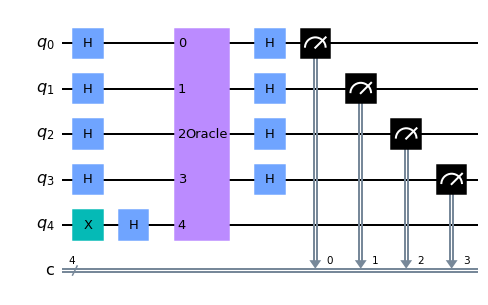

In [95]:
from qiskit import IBMQ, Aer, BasicAer, execute
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram
import numpy as np

def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        #print(bin(b))
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        #print(output)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

#### On affiche le résultat :

In [96]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(dj_circuit, backend)
if '0000' in job.result().get_counts(): 
    print("La fonction est constante")
else:
    print("La fonction est équilibrée")

La fonction est équilibrée


## Rapport  
Nous avons une fonction mathématique $f : {0,1}^𝑛 → {0,1}$. Cette fonction est une boite noire mais nous savons que cette elle est soit constante (la sortie est 0 ou 1 pour toutes les entrées) soit équilibrée (la sortie est 0 dans la moitié des cas, 1 dans les autres).  
Le principe de cette implémentation est d'utiliser n Qubits à |0> et rajouter un dernier Qubit à |1>
Il faut donc pouvoir créer cette fonction "boite noire" qu'on appellera Oracle. L'Oracle peut être soit équilibré soit constant. Il faut donc 2 conditions pour créer la fonction.  
On a défini la fonction **dj_oracle()** qui prend en argument le cas de la fonction (équilibré/constant) et le nombre de Qubit. Nous allons donc traiter les deux cas:  
- Equilibré : quand la fonction est équilibrée, il faut générer $\frac{n}{2}$ valeur à 1 et $\frac{n}{2}$ valeur à 0. Pour cela on créer un nombre entier aléatoire entre 1 et $2^n$ que l'on traduit ensuite en binaire. Ensuite, on applique une porte X pour les Qubit à |1> pour obtenir n états |0>. On applique après une porte CNOT au n Qubit vers le dernier Qubit. Pour finir, on replace des portes X aux Qubits qui en avait eu un au début.
- Constant : quand la fonction est constante, il faut générer un nombre entier aléatoire entre 0 et 1, on donne ce nombre en sortie pour toutes les entrées.  

Une  fois l'Oracle créer, nous pouvons l'implémenter sur le circuit.
Le circuit commence avec n porte d'Hadamard, et un Qubit avec une porte X et une H pour transformer les n premiers états en |+> et le dernier en |->.
On peut ensuite mesurer les n Qubit. Nous pouvons alors voir que l'on a 100% de chance d'avoir les n état à 1 si la fonction est balancée et 100% de chance d'avoir les n état à 0 si la fonction est constante.

# Exercice 2 : l'algorithme de Simon